In [1]:
import healpy as hp
from DS_healpix_fragmentation import one_pixel_fragmentation
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import circle
from tqdm.notebook import tqdm
from skimage.filters import gaussian

In [2]:
def find_biggest_pixel(ra, dec, radius):
    
    sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    nside = 1
    vec = hp.ang2vec(theta=sc.galactic.l.degree, phi=sc.galactic.b.degree,
                    lonlat=True)
    
    while len(set(hp.query_disc(nside, vec, np.radians(radius), inclusive=True, 
                                nest=True))) > 1:
        nside *= 2
        
    while len(set(hp.query_disc(nside, vec, np.radians(radius), inclusive=True, 
                                nest=True))) == 1:
        nside *= 2
    if nside > 1:
        nside = int(nside / 2)
    return nside, hp.query_disc(nside, vec, np.radians(radius), inclusive=True, nest=True)[0]

In [3]:
find_biggest_pixel(194.9551, 28.0021, 0.2)

(16, 255)

In [4]:
matr = one_pixel_fragmentation(16, 255, depth=12)

In [5]:
def matr2dict(matr):
    d = {}
    for i in range(matr.shape[0]):
        for j in range(matr.shape[1]):
            d[matr[i, j]] = (i, j)
    return d

In [6]:
mdict = matr2dict(matr)

In [8]:
c0 = (195.0648, 28.1200)
c1 = (194.8107, 28.1169)
c2 = (195.0868, 27.9064)
c3 = (194.8107, 27.8930)

In [7]:
f_nside = 2 ** 16

In [9]:
def radec2pix(ra, dec, nside):
    sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    return hp.ang2pix(nside, sc.galactic.l.degree, sc.galactic.b.degree, 
                      nest=True, lonlat=True)

In [10]:
corners = (radec2pix(*c0, f_nside), radec2pix(*c1, f_nside), 
           radec2pix(*c2, f_nside), radec2pix(*c3, f_nside))

In [11]:
corners_xy = [mdict[idx] for idx in corners]

In [12]:
corners_xy

[(2037, 3084), (2138, 3263), (2280, 2937), (2410, 3130)]

In [13]:
matr.shape

(4096, 4096)

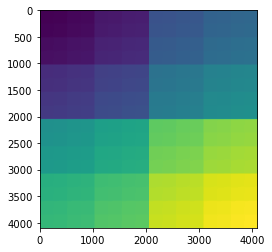

In [14]:
plt.imshow(matr)

In [15]:
pic_corners = np.zeros(matr.shape)

In [16]:
for x, y in corners_xy:
    pic_corners[circle(x, y, 17, shape=pic_corners.shape)] = 1

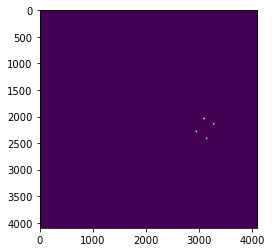

In [17]:
plt.imshow(pic_corners)

In [18]:
corners_xy = np.array(corners_xy)

In [19]:
corners_xy.shape

(4, 2)

In [20]:
print(corners_xy[:, 0].min(), corners_xy[:, 0].max())
print(corners_xy[:, 1].min(), corners_xy[:, 1].max())

2037 2410
2937 3263


In [21]:
map_size=512

In [103]:
one_circle = np.zeros(matr.shape, dtype=np.uint8)

In [104]:
sc = SkyCoord(ra=194.9551*u.degree, dec=28.0021*u.degree, frame='icrs')
circle_pix = hp.query_disc(f_nside, hp.ang2vec(sc.galactic.l.degree, sc.galactic.b.degree, 
                        lonlat=True), np.radians(0.2), nest=True, inclusive=True)

In [105]:
for pix in circle_pix:
    one_circle[mdict[pix]] = 1

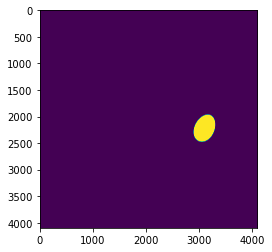

In [106]:
plt.imshow(one_circle)

In [26]:
circle_coords = [mdict[pix] for pix in circle_pix]

In [27]:
circle_coords = np.array(circle_coords)
circle_coords.shape

(158060, 2)

In [28]:
print(-(circle_coords[:, 0].min() - circle_coords[:, 0].max()))
print(-(circle_coords[:, 1].min() - circle_coords[:, 1].max()))

511
407


In [29]:
xmin = circle_coords[:, 0].min()
xmax = circle_coords[:, 0].max()
ymin = circle_coords[:, 1].min()
ymax = circle_coords[:, 1].max()

In [30]:
xmin, xmax, ymin, ymax, xmax - xmin, ymax - ymin

(1963, 2474, 2885, 3292, 511, 407)

In [31]:
xmax += map_size - (xmax - xmin)
ymax += map_size - (ymax - ymin)

In [32]:
xmin, xmax, ymin, ymax, xmax - xmin, ymax - ymin

(1963, 2475, 2885, 3397, 512, 512)

In [33]:
fin_matr = matr[xmin:xmax, ymin:ymax]

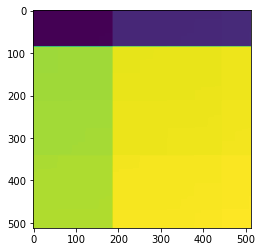

In [34]:
plt.imshow(fin_matr)

In [35]:
fin_dic_matr = matr2dict(fin_matr)
data_pic = np.zeros((map_size, map_size, 3))

In [36]:
with fits.open('/home/rt2122/Data/coma_sweep/south/sweep-190p025-200p030.fits') as hdul:
    data = hdul[1].data
    flux = (data['FLUX_G'], data['FLUX_R'], data['FLUX_Z'])
    ra = data['RA']
    dec = data['DEC']
    pixels = radec2pix(ra, dec, f_nside)
    
    coords = []
    for pix in tqdm(pixels):
        if pix in fin_dic_matr:
            coords.append(fin_dic_matr[pix])
            
    for i in tqdm(range(len(coords))):
        x, y = coords[i]
        for k, ch in enumerate(flux):
            data_pic[x, y, k] = max(data_pic[x, y, k], ch[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


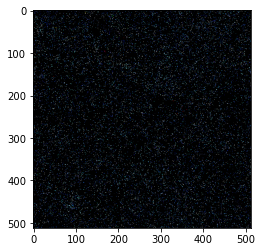

In [37]:
plt.imshow(data_pic)

In [46]:
gdata_pix = gaussian(data_pic, 30) 

<ipython-input-46-3f6ba5e3f919>:1: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  gdata_pix = gaussian(data_pic, 30)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


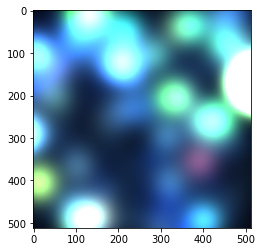

In [47]:
plt.imshow(gdata_pix)

In [129]:
centers = np.array([[194.8870, 28.0682],
    [195.0333, 27.9766],
    [194.8991, 27.9593]])
pix = radec2pix(centers[:, 0], centers[:, 1], f_nside)
cen_pic = np.zeros((map_size, map_size, 1), dtype=np.int32)
for i in range(3):
    x, y = fin_dic_matr[pix[i]]
    circle_idx = circle(x, y, 40, shape=cen_pic.shape)
    cen_pic[circle_idx] = 1

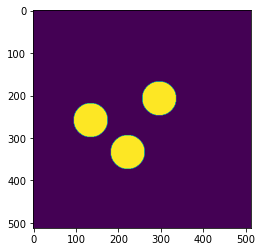

In [49]:
plt.imshow(cen_pic[:,:,0]*255)

In [42]:
one_circle = np.zeros(fin_matr.shape, dtype=np.uint8)
for pix in circle_pix:
    one_circle[fin_dic_matr[pix]] = 1

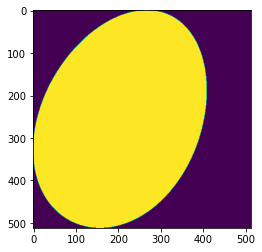

In [43]:
plt.imshow(one_circle)

In [74]:
def draw_circles(ra, dec, nside, shape, mdict, radius=None):
    if radius is None:
        radius = int(max(shape) / 20)
    pic = np.zeros(shape, dtype=np.uint8)
    pix = radec2pix(ra, dec, nside)
    coords = [mdict[p] for p in pix]
    for x, y in coords:
        pic[circle(x, y, radius, shape=shape)] = 1
    
    return pic

In [51]:
#############################

In [52]:
find_biggest_pixel(194.7764, 28.2066, 0.2)

(16, 255)

In [54]:
def draw_proper_circle(ra, dec, nside, shape, mdict, radius, mode='coords'):
    sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    vec = hp.ang2vec(theta=sc.galactic.l.degree, phi=sc.galactic.b.degree, lonlat=True)
    pix = hp.query_disc(nside, vec, np.radians(radius), nest=True, inclusive=True)
    coords = [mdict[p] for p in pix]
    if mode == 'coords':
        return np.array(coords)
    
    pic = np.zeros(shape, dtype=np.uint8)
    pic[coords, 0]=1
    return pic

In [55]:
other_circle = draw_proper_circle(194.7764, 28.2066, f_nside, matr.shape, mdict, 0.2)

In [66]:
def nearest_power(n):
    k = 0
    isPower = True
    while n > 0:
        if n % 2 != 0 and n > 1:
            isPower = False
        n //= 2
        k += 1
    if isPower:
        k -= 1
    return 2**k

In [86]:
def zoom_to_circle(coords, matr):
    xmin = coords[:, 0].min()
    xmax = coords[:, 0].max()
    ymin = coords[:, 1].min()
    ymax = coords[:, 1].max()
    xdif = xmax - xmin
    ydif = ymax - ymin
    
    map_size = nearest_power(max(xdif, ydif))
    xmax += map_size - xdif
    ymax += map_size - ydif
    
    return matr[xmin:xmax, ymin:ymax]

In [58]:
zoom_to_circle(other_circle, matr)

543 388


In [67]:
nearest_power(16)

16

In [85]:
omatr = zoom_to_circle(other_circle, matr)

4165


In [70]:
omdict = matr2dict(omatr)

In [71]:
obj = np.array([[194.6438, 28.3237],
               [194.8891, 28.2401],
               [194.8891, 28.0668]])

In [75]:
obj_pic = draw_circles(obj[:, 0], obj[:, 1], f_nside, omatr.shape, omdict)

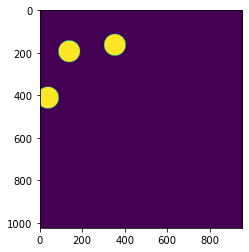

In [76]:
plt.imshow(obj_pic)

In [90]:
def draw_data(mdict, nside, shape, fits_name):
    data_pic = np.zeros(shape)
    with fits.open(fits_name) as hdul:
        
        data = hdul[1].data
        flux = (data['FLUX_G'], data['FLUX_R'], data['FLUX_Z'])
        ra = data['RA']
        dec = data['DEC']
        pixels = radec2pix(ra, dec, nside)

        coords = []
        for pix in tqdm(pixels):
            if pix in mdict:
                coords.append(mdict[pix])

        for i in tqdm(range(len(coords))):
            x, y = coords[i]
            for k, ch in enumerate(flux):
                data_pic[x, y, k] = max(data_pic[x, y, k], ch[i])
        return data_pic

In [91]:
opic = draw_data(omdict, f_nside, list(omatr.shape) + [3], 
                 '/home/rt2122/Data/coma_sweep/south/sweep-190p025-200p030.fits')

In [83]:
omatr.shape

(1024, 955)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


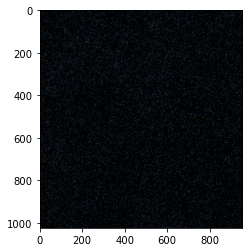

In [93]:
plt.imshow(opic)

In [92]:
opic.shape

(1024, 955, 3)

In [94]:
opic_gauss = gaussian(opic, 50)

<ipython-input-94-2ed8e6153751>:1: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  opic_gauss = gaussian(opic, 50)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


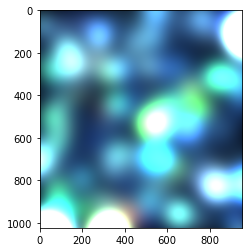

In [95]:
plt.imshow(opic_gauss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


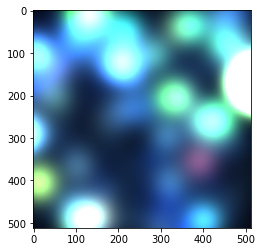

In [96]:
plt.imshow(gdata_pix)

In [98]:
big_pic = draw_data(mdict, f_nside, list(matr.shape) + [3], 
                    '/home/rt2122/Data/coma_sweep/south/sweep-190p025-200p030.fits')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


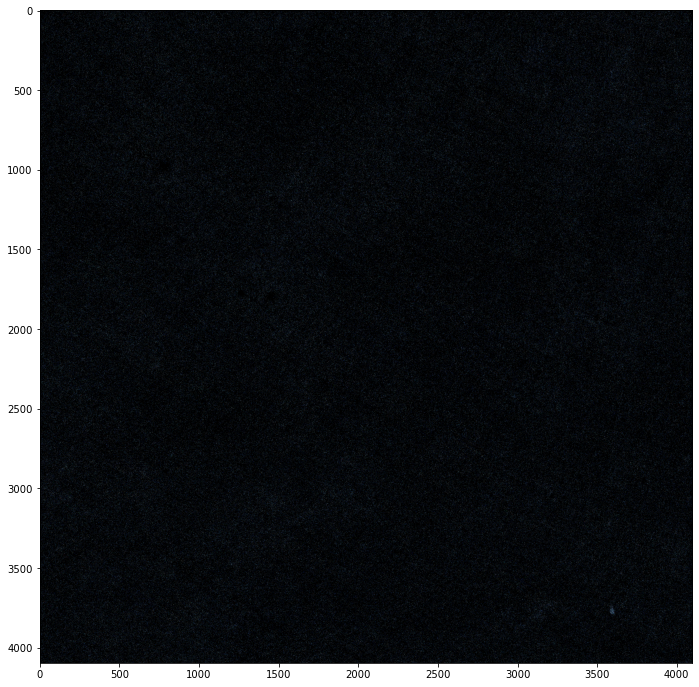

In [99]:
plt.figure(figsize=(12, 12))
plt.imshow(big_pic)

In [126]:
gbig_pic = gaussian(big_pic, 10)

<ipython-input-126-daeb40b66b54>:1: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  gbig_pic = gaussian(big_pic, 10)


In [107]:
one_circle.shape

(4096, 4096)

In [108]:
from DS_WCS_projections import show_pic

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


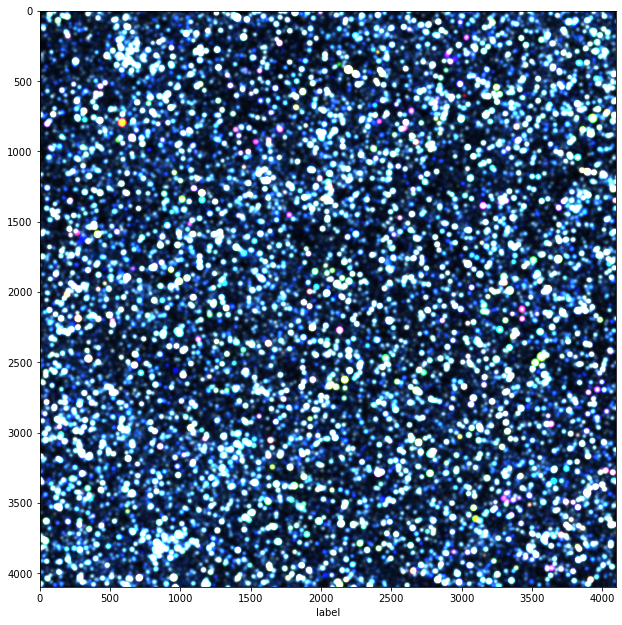

In [127]:
show_pic(gbig_pic)

In [114]:
one_circle = one_circle[0]

In [115]:
one_circle.shape

(4096, 4096)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


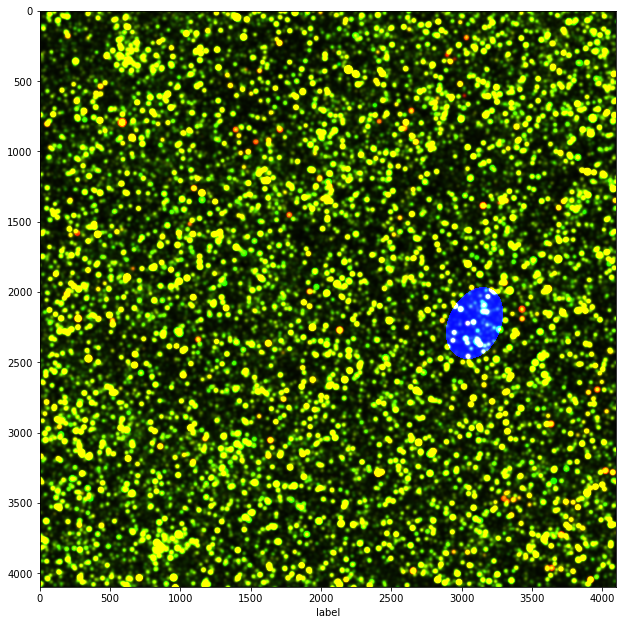

In [128]:
show_pic(np.dstack([gbig_pic[:, :, :2], one_circle.reshape((4096, 4096, 1))]))

In [118]:
one_circle.reshape((4096, 4096, 1)).shape


(4096, 4096, 1)

In [136]:
d3 = draw_circles(centers[:, 0], centers[:, 1], f_nside, matr.shape, mdict, 30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


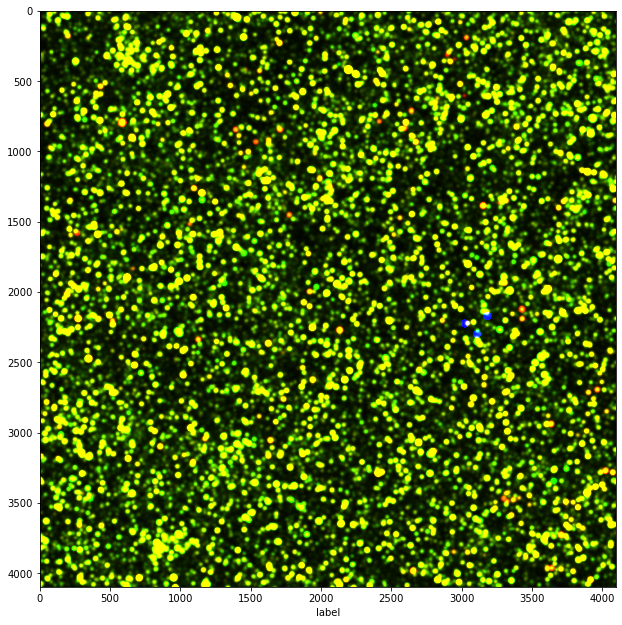

In [137]:
show_pic(np.dstack([gbig_pic[:, :, :2],d3]))